<h2>CIFAR-10 Image Classification</h2>
<h3>ST1504 Deep Learning CA1 Part B</h3>

<h4><b>References:</b></h4>
&#8226; RandomAugment: https://arxiv.org/pdf/1909.13719.pdf <br>
&#8226; EfficientNetV2: https://arxiv.org/pdf/2104.00298.pdf <br>
&#8226; Progressive Learning: https://www.fast.ai/2018/04/30/dawnbench-fastai/ <br>

<h4><b>Notebook Contents:</b></h4>
1. Data Exploration/Background Research<br>
2. Data Augmentation/Feature Engineering<br>
3. Modelling & Evaluation<br>
4. Model Improvement<br>

<h3><b>1. Data Exploration/ Background Research</b></h3>

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images, with 10 labels.

In [3]:
%load_ext tensorboard
from keras.layers import LSTM,ReLU, Dense,GaussianNoise, Bidirectional, Conv2D, AveragePooling2D, GlobalAveragePooling2D,MaxPooling2D, BatchNormalization,Add, DepthwiseConv2D,Multiply,Activation
from tensorflow.keras.activations import swish,sigmoid
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
import pandas as pd
import numpy as np
import seaborn as sns
import keras_efficientnet_v2
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
(image_train,labels_train),(image_test,labels_test)= tf.keras.datasets.cifar10.load_data()
#use l2 to reduce overfitting??
image_test = image_test/255
image_train = image_train/255
labels_test = to_categorical(labels_test,10)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


* Import all modules
* Load dataset
* Rescale test and train images

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
print(image_train.shape)
print(labels_train.shape)
print(image_test.shape)
print(labels_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 10)


In [60]:
unique, counts = np.unique(labels_train, return_counts=True)
var = dict(zip(unique, counts))
class_names = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']
for x in range(0,len(var)):
    var[class_names[x]] = var.pop(x)

* 50000 images of 32x32x3 for training and 50000 labels to pair with the images

* 10000 images of 32x32x3 for testing/validation and 10000 labels to pair with the images

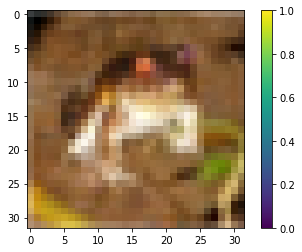

In [6]:
plt.figure()
plt.imshow(image_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

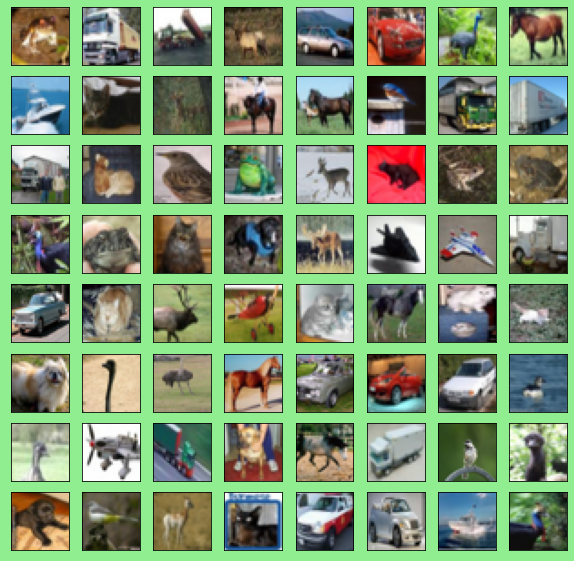

In [7]:
plt.figure(figsize=(10,10),facecolor="lightgreen")
for i in range(64): # 25 images
  plt.subplot(8,8,i+1) # matrix of 5 X 5 array
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image_train[i])
plt.show()

* Coloured images of different labels

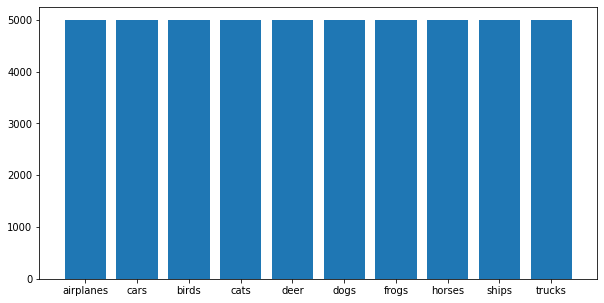

In [62]:
plt.figure(figsize=(10,5))
plt.bar(*zip(*var.items()))
plt.show()

* Exactly 5000 images per class, data is not imbalanced

<h2>Objectives/Tasks</h2>

* Be able to accurately identify the test images fed to the model
* Get highest possible accuracy and loss (>90% accuracy)
* Use regularization methods, data augmentation and different model architecture to reduce overfitting while improving accuracy and loss

<h3><b>2. Data Augmentation</h3></b>

* Defined function for progressive training
* Progressive training where we changed regularization values and image sizes in stages

In [9]:
def progressive_with_dropout_randaug(
    model,
    checkpoint,
    getAcc,
    getLoss,
    log,
    data_name="cifar10",
    total_epochs=36,
    batch_size=64,
    target_shapes=[128],
    dropouts=[0.4],
    dropout_layer=-2,
    magnitudes=[0]):
    
    stages = min([len(target_shapes), len(dropouts), len(magnitudes)])
    for stage, target_shape, dropout, magnitude in zip(range(stages), target_shapes, dropouts, magnitudes):
        print(">>>> stage: {}/{}, target_shape: {}, dropout: {}, magnitude: {}".format(stage + 1, stages, target_shape, dropout, magnitude))
        if len(dropouts) > 1 and isinstance(model.layers[dropout_layer], keras.layers.Dropout):
            print(">>>> Changing dropout rate to:", dropout)
            model.layers[dropout_layer].rate = dropout
        target_shape = (target_shape, target_shape)
        train_dataset, test_dataset = init_dataset(data_name=data_name, target_shape=target_shape, batch_size=batch_size, magnitude=magnitude, keep_shape=True)
        opt = tf.keras.optimizers.Adam()
        top3 = tf.keras.metrics.TopKCategoricalAccuracy(k=3,name='top_3_accuracy')
        model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy',top3])
        checkpoint = checkpoint
        getAcc = getAcc
        getLoss = getLoss
        log = log
        initial_epoch = stage * total_epochs // stages
        epochs = (stage + 1) * total_epochs // stages
        history = model.fit(
            train_dataset,
            epochs=epochs,
            initial_epoch=initial_epoch,
            validation_data=test_dataset,
        callbacks=[checkpoint,getAcc,getLoss,log],
        )


In [4]:
class ProcessImage:
    def __init__(self, target_shape=(300, 300), magnitude=0, keep_shape=False):
        self.target_shape, self.magnitude, self.keep_shape = target_shape, magnitude, keep_shape
        self.target_shape = target_shape if len(target_shape) == 2 else target_shape[:2]
        if magnitude > 0:
            from keras_efficientnet_v2 import augment
            translate_const, cutout_const = 100, 40
            print(
                ">>>> RandAugment: magnitude = %d, translate_const = %d, cutout_const = %d"
                % (magnitude, translate_const, cutout_const)
            )
            aa = augment.RandAugment(magnitude=magnitude, translate_const=translate_const, cutout_const=cutout_const)
            self.process = lambda img: aa.distort(img)
        elif magnitude == 0:
            self.process = lambda img: tf.image.random_flip_left_right(img)
        else:
            self.process = lambda img: img
    def __call__(self, datapoint):
        image = datapoint["image"]
        if self.keep_shape:
            cropped_shape = tf.reduce_min(tf.keras.backend.shape(image)[:2])
            image = tf.image.random_crop(image, (cropped_shape, cropped_shape, 3))
        input_image = tf.image.resize(image, self.target_shape,method = tf.image.ResizeMethod.BICUBIC)
        label = datapoint["label"]
        input_image = self.process(input_image)
        input_image = (tf.cast(input_image, tf.float32) - 127.5) / 128
        return input_image, label


def init_dataset(data_name="test123",target_shape=(300, 300), batch_size=64, all = 10000,buffer_size=1000, info_only=False, magnitude=0, keep_shape=False):
    train,test = tfds.load(data_name,split=['train','test'])
    dataset, info = tfds.load(data_name, with_info=True)
    num_classes = info.features["label"].num_classes
    total_images = info.splits["train"].num_examples
    if info_only:
        return total_images, num_classes

    AUTOTUNE = tf.data.AUTOTUNE
    train_process = ProcessImage(target_shape, magnitude, keep_shape=keep_shape)
    train = train.map(lambda xx: train_process(xx), num_parallel_calls=AUTOTUNE)

    test_process = ProcessImage(target_shape, magnitude=-1, keep_shape=keep_shape)
    test = test.map(lambda xx: test_process(xx))

    as_one_hot = lambda x, y: (x, tf.one_hot(y, num_classes))
    train_dataset = train.shuffle(buffer_size).batch(batch_size).map(as_one_hot).prefetch(buffer_size=AUTOTUNE)
    test_dataset = test.batch(batch_size).map(as_one_hot)
    return train_dataset,test_dataset

* Functions for creating blocks of EffNetv2 model

In [5]:
def stem(x,channels):
    x = Conv2D(channels,(3,3),(2,2),'same')(x)
    x = BatchNormalization()(x)
    x = Activation(swish)(x)
    return x
def block_0(x,channels):
    out = Conv2D(channels,(3,3),(1,1),'same')(x)
    out = BatchNormalization()(out)
    out = Activation(swish)(out)
    return Add()([x,out])
def block_1(x,channels,i):
    if i == 0:
        x = Conv2D(channels*2,(3,3),(2,2),padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation(swish)(x)
        x = Conv2D(channels,(1,1),(1,1),padding='same')(x)
        x = BatchNormalization()(x) 
        return x
    else:
        out = Conv2D(channels*4,(1,1),padding='same')(x)
        out = BatchNormalization()(out)
        out = Activation(swish)(out)
        out = Conv2D(channels,(1,1),(1,1),padding='same')(out)
        out = BatchNormalization()(out) 
        return Add()([out,x])

def block_2(x,channel_prev,channels,i):
    if i ==0 :
        x = Conv2D(channel_prev*4,(3,3),(2,2),padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation(swish)(x)
        x = Conv2D(channels,(1,1),(1,1),padding='same')(x)
        x = BatchNormalization()(x) 
        return x
    else:
        out = Conv2D(channels*4,(3,3),(1,1),padding='same')(x)
        out = BatchNormalization()(out)
        out = Activation(swish)(out)
        out = Conv2D(channels,(1,1),(1,1),padding='same')(out)
        out = BatchNormalization()(out) 
        return Add()([out,x])

def block_3(x,channel_prev,channels,i):
    if i ==0 :
        x = Conv2D(channels*2,(1,1),(1,1),padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation(swish)(x)
        x = DepthwiseConv2D((3,3),(2,2),padding='same')(x)
        x = BatchNormalization()(x) 
        x = Activation(swish)(x)
        out = tf.math.reduce_mean(x,(1,2),True)
        out = Conv2D(channel_prev/4,(1,1),(1,1),padding='same',use_bias=True)(out)
        out = Activation(swish)(out)
        out = Conv2D(channels*2,(1,1),(1,1),padding='same',use_bias=True)(out)
        out = Activation(sigmoid)(out)
        x = Multiply()([x,out])
        x = Conv2D(channels,(1,1),(1,1),padding='same',use_bias=True)(x)
        x = BatchNormalization()(x) 
        return x
    else:
        out = Conv2D(channels*4,(1,1),(1,1),padding='same')(x)
        out = BatchNormalization()(out)
        out = Activation(swish)(out)
        out = DepthwiseConv2D((3,3),(1,1),padding='same')(out)
        out = BatchNormalization()(out) 
        out = Activation(swish)(out)
        out2 = tf.math.reduce_mean(out,(1,2),True)
        out2 = Conv2D(channels/4,(1,1),(1,1),padding='same',use_bias=True)(out2)
        out2 = Activation(swish)(out2)
        out2 = Conv2D(channels*4,(1,1),(1,1),padding='same',use_bias=True)(out2)
        out2 = sigmoid(out2)
        out = Multiply()([out2,out])
        out = Conv2D(channels,(1,1),(1,1),padding='same',use_bias=True)(out)
        out = BatchNormalization()(out) 
        x = Add()([x,out])
        return x

def block_4(x,channel_prev,channels,i):
        if i == 0:
            x = Conv2D(channel_prev*6,(1,1),(1,1),padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation(swish)(x)
            x = DepthwiseConv2D((3,3),(1,1),padding='same')(x)
            x = BatchNormalization()(x) 
            x = Activation(swish)(x)
            out = tf.math.reduce_mean(x,(1,2),True)
            out = Conv2D(channel_prev/4,(1,1),(1,1),padding='same',use_bias=True)(out)
            out = Activation(swish)(out)
            out = Conv2D(channel_prev*6,(1,1),(1,1),padding='same',use_bias=True)(out)
            out = Activation(sigmoid)(out)
            x = Multiply()([x,out])
            x = Conv2D(channels,(1,1),(1,1),padding='same',use_bias=True)(x)
            x = BatchNormalization()(x) 
            return x
        else:
            out = Conv2D(channels*6,(1,1),(1,1),padding='same')(x)
            out = BatchNormalization()(out)
            out = Activation(swish)(out)
            out = DepthwiseConv2D((3,3),(1,1),padding='same')(out)
            out = BatchNormalization()(out) 
            out = Activation(swish)(out)
            out2 = tf.math.reduce_mean(out,(1,2),True)
            out2 = Conv2D(channels/4,(1,1),(1,1),padding='same',use_bias=True)(out2)
            out2 = Activation(swish)(out2)
            out2 = Conv2D(channels*6,(1,1),(1,1),padding='same',use_bias=True)(out2)
            out2 = Activation(sigmoid)(out2)
            out = Multiply()([out2,out])
            out = Conv2D(channels,(1,1),(1,1),padding='same',use_bias=True)(out)
            out = BatchNormalization()(out) 
            x = Add()([x,out])
            return x

def block_5(x,channel_prev,channels,i):
    if i ==0:
        x = Conv2D(channel_prev*6,(1,1),(1,1),padding='same')(x)
        x = BatchNormalization()(x)
        x =  Activation(swish)(x)
        x = DepthwiseConv2D((3,3),(2,2),padding='same')(x)
        x = BatchNormalization()(x) 
        x =  Activation(swish)(x)
        out = tf.math.reduce_mean(x,(1,2),True)
        out = Conv2D(channel_prev/4,(1,1),(1,1),padding='same',use_bias=True)(out)
        out =  Activation(swish)(out)
        out = Conv2D(channel_prev*6,(1,1),(1,1),padding='same',use_bias=True)(out)
        out = Activation(sigmoid)(out)
        x = Multiply()([x,out])
        x = Conv2D(channels,(1,1),(1,1),padding='same',use_bias=True)(x)
        x = BatchNormalization()(x) 
        return x
    else:
        out = Conv2D(channels*6,(1,1),(1,1),padding='same')(x)
        out = BatchNormalization()(out)
        out =  Activation(swish)(out)
        out = DepthwiseConv2D((3,3),(1,1),padding='same')(out)
        out = BatchNormalization()(out) 
        out =  Activation(swish)(out)
        out2 = tf.math.reduce_mean(out,(1,2),True)
        out2 = Conv2D(channels/4,(1,1),(1,1),padding='same',use_bias=True)(out2)
        out2 = Activation(swish)(out2)
        out2 = Conv2D(channels*6,(1,1),(1,1),padding='same',use_bias=True)(out2)
        out2 = Activation(sigmoid)(out2)
        out = Multiply()([out2,out])
        out = Conv2D(channels,(1,1),(1,1),padding='same',use_bias=True)(out)
        out = BatchNormalization()(out) 
        x = Add()([x,out])
        return x

def block_6(x,channel_prev,channels,i):
    if i ==0:
        x = Conv2D(channel_prev*6,(1,1),(1,1),padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation(swish)(x)
        x = DepthwiseConv2D((3,3),(1,1),padding='same')(x)
        x = BatchNormalization()(x) 
        x = Activation(swish)(x)
        out = tf.math.reduce_mean(x,(1,2),True)
        out = Conv2D(channel_prev/4,(1,1),(1,1),padding='same',use_bias=True)(out)
        out = Activation(swish)(out)
        out = Conv2D(channel_prev*6,(1,1),(1,1),padding='same',use_bias=True)(out)
        out = Activation(sigmoid)(out)
        x = Multiply()([x,out])
        x = Conv2D(channels,(1,1),(1,1),padding='same',use_bias=True)(x)
        x = BatchNormalization()(x) 
        return x    
    else:
        out = Conv2D(channels*6,(1,1),(1,1),padding='same')(x)
        out = BatchNormalization()(out)
        out = Activation(swish)(out)
        out = DepthwiseConv2D((3,3),(1,1),padding='same')(out)
        out = BatchNormalization()(out) 
        out = Activation(swish)(out)
        out2 = tf.math.reduce_mean(out,(1,2),True)
        out2 = Conv2D(channels/4,(1,1),(1,1),padding='same',use_bias=True)(out2)
        out2 = Activation(swish)(out2)
        out2 = Conv2D(channels*6,(1,1),(1,1),padding='same',use_bias=True)(out2)
        out2 = Activation(sigmoid)(out2)
        out = Multiply()([out2,out])
        out = Conv2D(channels,(1,1),(1,1),padding='same',use_bias=True)(out)
        out = BatchNormalization()(out) 
        x = Add()([x,out])
        return x

<h3><b>3. Modelling & Evaluation</h3></b>

<h3>Metrics Used</h3>

* Top 1 accuracy
* Top 3 accuracy
* Loss

* Simple CNN with few Conv2D layers, BatchNorm and ReLU after every Conv2D, add some MaxPooling and a GlobalAveragePolling at the end, end with Dense softmax
* Default Adam optimizer

In [26]:
input = tf.keras.Input((32,32,3))
x = Conv2D(32,(3,3),(1,1),'same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(32,(3,3),(1,1),'same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D()(x)
x = Conv2D(64,(3,3),(2,2),'same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(64,(3,3),(1,1),'same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D()(x)
x = Conv2D(128,(3,3),(1,1),'same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(128,(3,3),(1,1),'same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(10,'softmax')(x)
opt = tf.keras.optimizers.Adam()
baseline = keras.models.Model(inputs=input,outputs = x)
top3 = tf.keras.metrics.TopKCategoricalAccuracy(k=3,name='top_3_accuracy')

.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy',top3])
log_base = CSVLogger('tmp/baselineB.csv',separator = ',',append=False)
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/baselineB.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/baselineB_Acc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/baselineB_Loss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')

In [6]:
input_shape = ( 32, 32, 3)
batch_size = 128
train_dataset, test_dataset = init_dataset(data_name="cifar10", target_shape=input_shape, batch_size=batch_size,magnitude=-1,keep_shape=True)

In [ ]:
baseline_history = baseline.fit(train_dataset,epochs=70,validation_data=test_dataset,callbacks=[checkpoint,getAcc,getLoss,log_base])

Epoch 1/70
391/391 [==============================] - ETA: 0s - loss: 1.2478 - accuracy: 0.5535 - top_3_accuracy: 0.8436
Epoch 00001: saving model to tmp/checkpoint/baselineB.hdf5

Epoch 00001: val_accuracy improved from -inf to 0.60700, saving model to tmp/checkpoint/baselineB_Acc.hdf5

Epoch 00001: val_loss improved from inf to 1.12104, saving model to tmp/checkpoint/baselineB_Loss.hdf5
391/391 [==============================] - 26s 48ms/step - loss: 1.2478 - accuracy: 0.5535 - top_3_accuracy: 0.8436 - val_loss: 1.1210 - val_accuracy: 0.6070 - val_top_3_accuracy: 0.8735
Epoch 2/70
390/391 [============================>.] - ETA: 0s - loss: 0.8858 - accuracy: 0.6884 - top_3_accuracy: 0.9135
Epoch 00002: saving model to tmp/checkpoint/baselineB.hdf5

Epoch 00002: val_accuracy improved from 0.60700 to 0.62480, saving model to tmp/checkpoint/baselineB_Acc.hdf5

Epoch 00002: val_loss did not improve from 1.12104
391/391 [==============================] - 11s 28ms/step - loss: 0.8860 - accu

In [16]:
baseline.load_weights('tmp/checkpoint/baselineB_Acc.hdf5')
scoreAcc = baseline.evaluate(test_dataset)
baseline.load_weights('tmp/checkpoint/baselineB_Loss.hdf5')
scoreLoss = baseline.evaluate(test_dataset)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

79/79 [==============================] - 1s 6ms/step - loss: 0.8048 - accuracy: 0.7437 - top_3_accuracy: 0.9415
Best Acc Test Loss: 1.1501727104187012
Best Acc Test Accuracy: 78.41 %
Best Loss Test Loss: 0.8048075437545776
Best Loss Test Accuracy: 74.37 %


* Okay test accuracy and loss
* 78.41% max is decent
* Attempt to achieve at least >85%

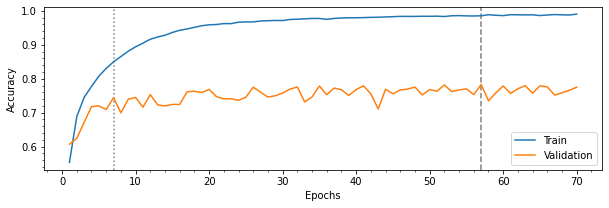

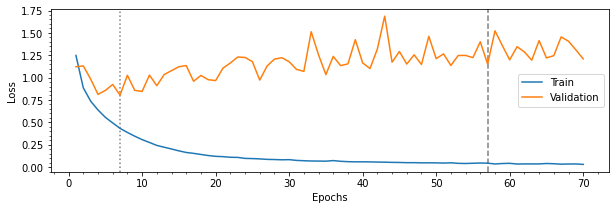

In [19]:
data = pd.read_csv('tmp/baselineB.csv')
max_val_acc_epoch = np.argmax(data['val_accuracy'])+1
max_val_loss_epoch = np.argmin(data['val_loss'])+1
epochs = range(1, len(data['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,data['accuracy'], label='Train')
plt.plot(epochs,data['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,data['loss'], label='Train')
plt.plot(epochs,data['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

* Heavy overfitting can be observed
* Test accuracy only at ~80% when train acc at >95%
* Validation seems very unstable

<h4>EfficientNetV2S</h4>

In [7]:
input = tf.keras.Input((300,300,3))
x = stem(input,24)
for i in range(2):
    x = block_0(x,24)
for i in range(4):
    x = block_1(x,48,i)
for i in range(4):
    x = block_2(x,48,64,i)
for i in range(6):
    x = block_3(x,64,128,i)
for i in range(9):
    x = block_4(x,128,160,i)
for i in range(15):
    x = block_5(x,160,256,i)
x = Conv2D(1280,(1,1),(1,1),padding='same')(x)
x = BatchNormalization()(x) 
x = swish(x)
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = Dense(10,activation='softmax')(x)
effnetv2s = tf.keras.models.Model(inputs=input, outputs = x)
opt = tf.keras.optimizers.Adam()
top3 = tf.keras.metrics.TopKCategoricalAccuracy(k=3,name='top_3_accuracy')
effnetv2s.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy',top3])
log_EffNetv2 = CSVLogger('tmp/EffNetV2S.csv',separator = ',',append=False)
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/EffNetV2S.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/EffNetV2S_Acc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/EffNetV2S_Loss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')

* Create model based on efficient net v2 architecture
* ResNet style block of bottleneck CNN architecture, control channel output
* FusedMBConv and MBConv blocks
* MBConv has depthwise convolutions which are more efficient than normal conv layers, less FLOPS and parameters
* FusedMBConv has conv2d layers which can utilize modern accelerators
* Combine both for reduced computational cost with minimal performance reduction 

* Used Swish activation function instead of ReLU for non-lineararity function
* Swish is similar to ReLU, but uses sigmoid to create a smooth network landscape, making it easier to find minima

* Sqeeuze and Excitation block to improve channel interdependencies
* Squeeze features maps into single value, feed through 2 layer nn
* Values used as weights on original feature maps, scaling them adaptively based on importance

In [8]:
input_shape = ( 300, 300, 3)
batch_size = 128
train_dataset,test_dataset = init_dataset(data_name="cifar10", target_shape=input_shape, batch_size=batch_size,magnitude=-1,keep_shape=True)

* Resize images to 300 x 300

In [ ]:
history = effnetv2s.fit(train_dataset,batch_size = 128 ,validation_data = test_dataset,epochs=70,callbacks=[checkpoint,getAcc,getLoss,log_EffNetv2])

Epoch 1/70
391/391 [==============================] - ETA: 0s - loss: 1.6181 - accuracy: 0.3910 - top_3_accuracy: 0.7337
Epoch 00001: saving model to ./checkpoint/EffNetV2S_AUG.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)



Epoch 00001: val_accuracy improved from -inf to 0.10000, saving model to ./checkpoint/EffNetV2S_Acc_AUG.hdf5

Epoch 00001: val_loss improved from inf to 2.71473, saving model to ./checkpoint/EffNetV2S_Loss_AUG.hdf5
391/391 [==============================] - 350s 555ms/step - loss: 1.6181 - accuracy: 0.3910 - top_3_accuracy: 0.7337 - val_loss: 2.7147 - val_accuracy: 0.1000 - val_top_3_accuracy: 0.3001
Epoch 2/70
391/391 [==============================] - ETA: 0s - loss: 1.0305 - accuracy: 0.6359 - top_3_accuracy: 0.8902
Epoch 00002: saving model to ./checkpoint/EffNetV2S_AUG.hdf5

Epoch 00002: val_accuracy improved from 0.10000 to 0.28890, saving model to ./checkpoint/EffNetV2S_Acc_AUG.hdf5

Epoch 00002: val_loss did not improve from 2.71473
391/391 [==============================] - 112s 287ms/step - loss: 1.0305 - accuracy: 0.6359 - top_3_accuracy: 0.8902 - val_loss: 6.6122 - val_accuracy: 0.2889 - val_top_3_accuracy: 0.5521
Epoch 3/70
391/391 [==============================] - ETA: 

In [ ]:
effnetv2s.load_weights('tmp/checkpoint/EffNetV2S_Acc.hdf5')
scoreAcc = effnetv2s.evaluate(test_dataset)
effnetv2s.load_weights('tmp/checkpoint/EffNetV2S_Loss.hdf5')
scoreLoss = effnetv2s.evaluate(test_dataset)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

79/79 [==============================] - 13s 147ms/step - loss: 0.5535 - accuracy: 0.8815 - top_3_accuracy: 0.9788
Best Acc Test Loss: 0.5780285596847534
Best Acc Test Accuracy: 89.0 %
Best Loss Test Loss: 0.553464412689209
Best Loss Test Accuracy: 88.14999999999999 %


* Increase in test accuracy and loss of 89% and 0.553 compared to baseline with 78% and 0.8
* Test accuracy can reach >85%
* Overall improvement

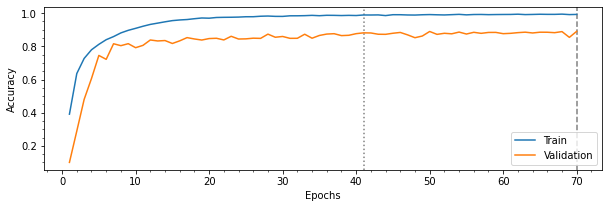

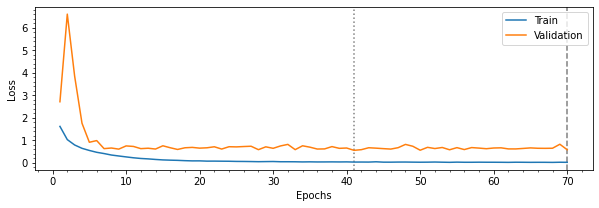

In [2]:
data = pd.read_csv('tmp/EffNetV2S.csv')
max_val_acc_epoch = np.argmax(data['val_accuracy'])+1
max_val_loss_epoch = np.argmin(data['val_loss'])+1
epochs = range(1, len(data['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,data['accuracy'], label='Train')
plt.plot(epochs,data['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,data['loss'], label='Train')
plt.plot(epochs,data['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

* Improvement in all metrics for EffNetV2 model
* Not as prone to overfitting
* Graph looks a lot more stable
* Loss is not increasing rapidly
* Model complexity has improved preformance

<h4>EffNetV2 Small with RandAugment

In [ ]:
input = tf.keras.Input((300,300,3))
x = stem(input,24)
for i in range(2):
    x = block_0(x,24)
for i in range(4):
    x = block_1(x,48,i)
for i in range(4):
    x = block_2(x,48,64,i)
for i in range(6):
    x = block_3(x,64,128,i)
for i in range(9):
    x = block_4(x,128,160,i)
for i in range(15):
    x = block_5(x,160,256,i)
x = Conv2D(1280,(1,1),(1,1),padding='same')(x)
x = BatchNormalization()(x) 
x = swish(x)
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = Dense(10,activation='softmax')(x)
effnetv2s_AUG = tf.keras.models.Model(inputs=input, outputs = x)
opt = tf.keras.optimizers.Adam()
top3 = tf.keras.metrics.TopKCategoricalAccuracy(k=3,name='top_3_accuracy')
effnetv2s_AUG.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy',top3])

log_EffNetv2 = CSVLogger('tmp/EffNetV2S_AUG.csv',separator = ',',append=False)
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/EffNetV2S_AUG.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/EffNetV2S_Acc_AUG.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/EffNetV2S_Loss_AUG.hdf5',verbose=True,save_best_only=True,monitor='val_loss')

In [ ]:
input_shape = ( 300, 300, 3)
batch_size = 128
train_dataset,test_dataset = init_dataset(data_name="cifar10", target_shape=input_shape, batch_size=batch_size,magnitude=15,keep_shape=True)

>>>> RandAugment: magnitude = 15, translate_const = 100, cutout_const = 40


In [ ]:
history_AUG = effnetv2s_AUG.fit(train_dataset,batch_size = 128 ,validation_data = test_dataset,epochs=70,callbacks=[checkpoint,getAcc,getLoss,log_EffNetv2])

In [ ]:
effnetv2s_AUG.load_weights('tmp/checkpoint/EffNetV2S_Acc_AUG.hdf5')
scoreAcc = effnetv2s_AUG.evaluate(test_dataset)
effnetv2s_AUG.load_weights('tmp/checkpoint/EffNetV2S_Loss_AUG.hdf5')
scoreLoss = effnetv2s_AUG.evaluate(test_dataset)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

79/79 [==============================] - 14s 152ms/step - loss: 0.5622 - accuracy: 0.8879 - top_3_accuracy: 0.9802
Best Acc Test Loss: 0.5729730725288391
Best Acc Test Accuracy: 89.41 %
Best Loss Test Loss: 0.5621612071990967
Best Loss Test Accuracy: 88.79 %


* Loss remains similar for both non-augmented and augmented
* Slight improvement in test accuracy of ~0.4%

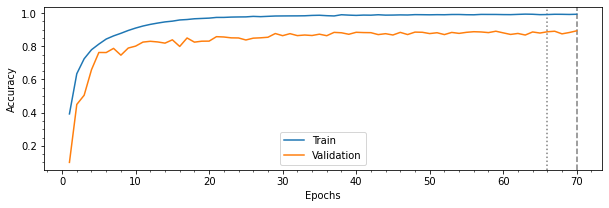

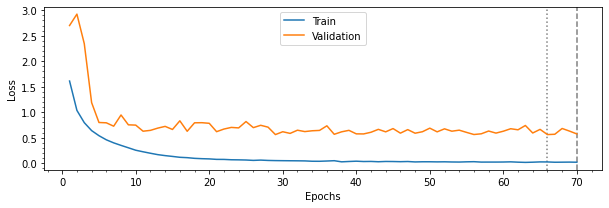

In [4]:
data = pd.read_csv('tmp/EffNetV2S_AUG.csv')
max_val_acc_epoch = np.argmax(data['val_accuracy'])+1
max_val_loss_epoch = np.argmin(data['val_loss'])+1
epochs = range(1, len(data['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,data['accuracy'], label='Train')
plt.plot(epochs,data['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,data['loss'], label='Train')
plt.plot(epochs,data['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

* Graphs look very similar in nature, not much changed

<h4>Transfer learning using pretrained weight (ImageNet21K)

* Using EffNetV2S model with pretrained weights from ImageNet21K
* Imagenet21K has over 13 million images and around 21000 classes

In [ ]:
import keras_efficientnet_v2
model = keras_efficientnet_v2.EfficientNetV2S(pretrained='imagenet21k',num_classes=0,input_shape=(300, 300, 3))
out = model.output

out = GlobalAveragePooling2D()(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(10,activation='softmax')(out)

ev2_pre = keras.models.Model(inputs=model.inputs[0],outputs = out)
top3 = tf.keras.metrics.TopKCategoricalAccuracy(k=3,name='top_3_accuracy')
model.trainable = True

ev2_pre.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',top3])
log_pre = CSVLogger('tmp/EffNetV2S_Pretrained.csv',separator = ',',append=False)
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/EffNetV2S_Pretrained.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/EffNetV2S_Acc_Pretrained.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/EffNetV2S_Loss_Pretrained.hdf5',verbose=True,save_best_only=True,monitor='val_loss')

In [ ]:
input_shape = ( 300, 300, 3)
batch_size = 128
train_dataset,test_dataset = init_dataset(data_name="cifar10", target_shape=input_shape, batch_size=batch_size,magnitude=15,keep_shape=True)

>>>> RandAugment: magnitude = 15, translate_const = 100, cutout_const = 40


In [ ]:
history_pre = ev2_pre.fit(train_dataset,validation_data = test_dataset,epochs=70,callbacks=[getAcc,getLoss,checkpoint,log_pre])

Epoch 1/70
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


391/391 [==============================] - ETA: 0s - loss: 0.9983 - accuracy: 0.6582 - top_3_accuracy: 0.8762
Epoch 00001: val_accuracy improved from -inf to 0.89980, saving model to ./checkpoint/EffNetV2S_Acc_Pretrained.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)



Epoch 00001: val_loss improved from inf to 0.29104, saving model to ./checkpoint/EffNetV2S_Loss_Pretrained.hdf5

Epoch 00001: saving model to ./checkpoint/EffNetV2S_Pretrained.hdf5
391/391 [==============================] - 344s 571ms/step - loss: 0.9983 - accuracy: 0.6582 - top_3_accuracy: 0.8762 - val_loss: 0.2910 - val_accuracy: 0.8998 - val_top_3_accuracy: 0.9851
Epoch 2/70
391/391 [==============================] - ETA: 0s - loss: 0.6696 - accuracy: 0.7691 - top_3_accuracy: 0.9351
Epoch 00002: val_accuracy improved from 0.89980 to 0.92610, saving model to ./checkpoint/EffNetV2S_Acc_Pretrained.hdf5

Epoch 00002: val_loss improved from 0.29104 to 0.22323, saving model to ./checkpoint/EffNetV2S_Loss_Pretrained.hdf5

Epoch 00002: saving model to ./checkpoint/EffNetV2S_Pretrained.hdf5
391/391 [==============================] - 147s 373ms/step - loss: 0.6696 - accuracy: 0.7691 - top_3_accuracy: 0.9351 - val_loss: 0.2232 - val_accuracy: 0.9261 - val_top_3_accuracy: 0.9899
Epoch 3/70
391

In [ ]:
ev2_pre.load_weights('./checkpoint/EffNetV2S_Acc_Pretrained.hdf5')
scoreAcc = ev2_pre.evaluate(test_dataset)
ev2_pre.load_weights('./checkpoint/EffNetV2S_Loss_Pretrained.hdf5')
scoreLoss = ev2_pre.evaluate(test_dataset)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

79/79 [==============================] - 22s 259ms/step - loss: 0.1107 - accuracy: 0.9665 - top_3_accuracy: 0.9981
Best Acc Test Loss: 0.1204100176692009
Best Acc Test Accuracy: 96.67999999999999 %
Best Loss Test Loss: 0.11072955280542374
Best Loss Test Accuracy: 96.65 %


* Significant improvement of model
* Test accuracy has improved by 7% to ~96.6% compared to 89.41% with just training on CIFAR-10 using EffNetV2S
* Loss has improved ~0.562 to ~0.11

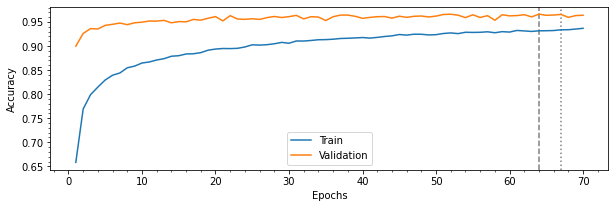

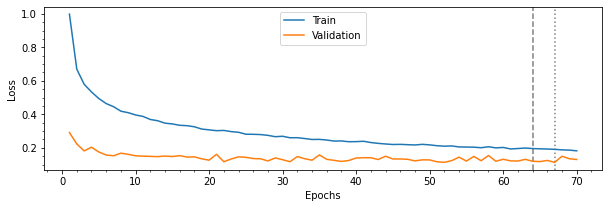

In [65]:
data = pd.read_csv('tmp/EffNetV2S_Pretrained.csv')
max_val_acc_epoch = np.argmax(data['val_accuracy'])+1
max_val_loss_epoch = np.argmin(data['val_loss'])+1
epochs = range(1, len(data['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,data['accuracy'], label='Train')
plt.plot(epochs,data['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,data['loss'], label='Train')
plt.plot(epochs,data['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

* Significant generalisation improvement vs just EffNetV2S
* Model does not overfit

<h4>Progressive Learning with EffNetV2S

* Use progressive learning on EffNetV2S
* Split training into 4 stages, total 72 epochs, 18 epochs per stage
* Start with small image size, lesser regularization and less augmentation magnitude, increase image size, regularization and augmentation magnitude.
* Train model with smaller images and smaller regularization, help model learn faster and easier
* Gradually increase image size to give models more information and stronger regularization to increase difficulty of learning to improve generalization

In [ ]:
input = tf.keras.Input((None,None,3))
x = stem(input,24)
for i in range(2):
    x = block_0(x,24)
for i in range(4):
    x = block_1(x,48,i)
for i in range(4):
    x = block_2(x,48,64,i)
for i in range(6):
    x = block_3(x,64,128,i)
for i in range(9):
    x = block_4(x,128,160,i)
for i in range(15):
    x = block_5(x,160,256,i)
x = Conv2D(1280,(1,1),(1,1),padding='same')(x)
x = BatchNormalization()(x) 
x = swish(x)
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = Dense(10,activation='softmax')(x)
effnetv2s_AUG = tf.keras.models.Model(inputs=input, outputs = x)
log_prog = CSVLogger('tmp/EffNetV2S_AUG_Prog.csv',separator = ',',append=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/EffNetV2S_AUG_Prog.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/EffNetV2S_Acc_AUG_Prog.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/EffNetV2S_Loss_AUG_Prog.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
history = progressive_with_dropout_randaug(effnetv2s_AUG,checkpoint,getAcc,getLoss,log_prog,data_name="cifar10",
total_epochs=72,batch_size=128,dropout_layer=-2,
target_shapes=[128, 185, 242, 300],dropouts=[0.1, 0.2, 0.3, 0.4],magnitudes=[5, 8, 12, 15])

>>>> stage: 1/4, target_shape: 128, dropout: 0.1, magnitude: 5
>>>> Changing dropout rate to: 0.1
>>>> RandAugment: magnitude = 5, translate_const = 100, cutout_const = 40
Epoch 1/18
391/391 [==============================] - ETA: 0s - loss: 1.6362 - accuracy: 0.3910 - top_3_accuracy: 0.7312
Epoch 00001: saving model to ./checkpoint/EffNetV2S_AUG_Prog.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)



Epoch 00001: val_accuracy improved from -inf to 0.10000, saving model to ./checkpoint/EffNetV2S_Acc_AUG_Prog.hdf5

Epoch 00001: val_loss improved from inf to 2.45504, saving model to ./checkpoint/EffNetV2S_Loss_AUG_Prog.hdf5
391/391 [==============================] - 312s 437ms/step - loss: 1.6362 - accuracy: 0.3910 - top_3_accuracy: 0.7312 - val_loss: 2.4550 - val_accuracy: 0.1000 - val_top_3_accuracy: 0.3000
Epoch 2/18
391/391 [==============================] - ETA: 0s - loss: 1.0824 - accuracy: 0.6155 - top_3_accuracy: 0.8785
Epoch 00002: saving model to ./checkpoint/EffNetV2S_AUG_Prog.hdf5

Epoch 00002: val_accuracy improved from 0.10000 to 0.55270, saving model to ./checkpoint/EffNetV2S_Acc_AUG_Prog.hdf5

Epoch 00002: val_loss improved from 2.45504 to 1.79611, saving model to ./checkpoint/EffNetV2S_Loss_AUG_Prog.hdf5
391/391 [==============================] - 73s 186ms/step - loss: 1.0824 - accuracy: 0.6155 - top_3_accuracy: 0.8785 - val_loss: 1.7961 - val_accuracy: 0.5527 - val_

In [ ]:
effnetv2s_AUG.load_weights('tmp/checkpoint/EffNetV2S_Acc_AUG_Prog.hdf5')
scoreAcc = effnetv2s_AUG.evaluate(test_dataset)
effnetv2s_AUG.load_weights('tmp/checkpoint/EffNetV2S_Loss_AUG_Prog.hdf5')
scoreLoss = effnetv2s_AUG.evaluate(test_dataset)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

79/79 [==============================] - 13s 148ms/step - loss: 0.4325 - accuracy: 0.9074 - top_3_accuracy: 0.9848
Best Acc Test Loss: 0.4324556887149811
Best Acc Test Accuracy: 90.74 %
Best Loss Test Loss: 0.4324556887149811
Best Loss Test Accuracy: 90.74 %


* Progressive learning improves EffNetV2S model by ~1.3%
* Improved loss by ~0.12
* Model is able to generalize better using this method of training, reduction in training time as well as improvement in performance

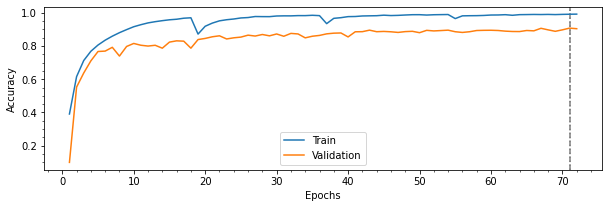

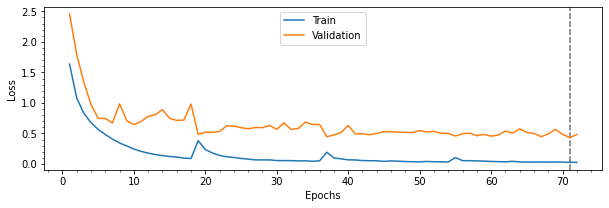

In [5]:
data = pd.read_csv('tmp/EffNetV2S_AUG_Prog.csv')
max_val_acc_epoch = np.argmax(data['val_accuracy'])+1
max_val_loss_epoch = np.argmin(data['val_loss'])+1
epochs = range(1, len(data['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,data['accuracy'], label='Train')
plt.plot(epochs,data['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,data['loss'], label='Train')
plt.plot(epochs,data['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

* Model is less prone to overfitting
* Performance is improved

<h4>Progressive training with EffNetV2 Pretrained (ImageNet21K)

In [ ]:
model = keras_efficientnet_v2.EfficientNetV2S(pretrained='imagenet21k',num_classes=0,input_shape=(None, None, 3))
out = model.output
model.trainable = True
out = GlobalAveragePooling2D()(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(10,activation='softmax')(out)

ev2_pre = keras.models.Model(inputs=model.inputs[0],outputs = out)
top3 = tf.keras.metrics.TopKCategoricalAccuracy(k=3,name='top_3_accuracy')
log_pre = CSVLogger('./EffNetV2S_Pretrained_Prog.csv',separator = ',',append=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('./checkpoint/EffNetV2S_Pretrained_Prog.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('./checkpoint/EffNetV2S_Acc_Pretrained_Prog.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('./checkpoint/EffNetV2S_Loss_Pretrained_Prog.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
history = progressive_with_dropout_randaug(ev2_pre,checkpoint,getAcc,getLoss,log_pre,data_name="cifar10",
    total_epochs=72,batch_size=128,dropout_layer=-2,
    target_shapes=[128, 185, 242, 300],dropouts=[0.1, 0.2, 0.3, 0.4],magnitudes=[5, 8, 12, 15])

194658304/194646348 [==============================] - 3s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-s-21k.h5
>>>> stage: 1/4, target_shape: 128, dropout: 0.1, magnitude: 5
>>>> Changing dropout rate to: 0.1
>>>> RandAugment: magnitude = 5, translate_const = 100, cutout_const = 40
Epoch 1/18
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


391/391 [==============================] - ETA: 0s - loss: 0.7126 - accuracy: 0.7656 - top_3_accuracy: 0.9359
Epoch 00001: saving model to ./checkpoint/EffNetV2S_Pretrained_Prog.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)



Epoch 00001: val_accuracy improved from -inf to 0.92740, saving model to ./checkpoint/EffNetV2S_Acc_Pretrained_Prog.hdf5

Epoch 00001: val_loss improved from inf to 0.21448, saving model to ./checkpoint/EffNetV2S_Loss_Pretrained_Prog.hdf5
391/391 [==============================] - 271s 390ms/step - loss: 0.7126 - accuracy: 0.7656 - top_3_accuracy: 0.9359 - val_loss: 0.2145 - val_accuracy: 0.9274 - val_top_3_accuracy: 0.9913
Epoch 2/18
391/391 [==============================] - ETA: 0s - loss: 0.4158 - accuracy: 0.8596 - top_3_accuracy: 0.9740
Epoch 00002: saving model to ./checkpoint/EffNetV2S_Pretrained_Prog.hdf5

Epoch 00002: val_accuracy improved from 0.92740 to 0.93040, saving model to ./checkpoint/EffNetV2S_Acc_Pretrained_Prog.hdf5

Epoch 00002: val_loss improved from 0.21448 to 0.20756, saving model to ./checkpoint/EffNetV2S_Loss_Pretrained_Prog.hdf5
391/391 [==============================] - 71s 180ms/step - loss: 0.4158 - accuracy: 0.8596 - top_3_accuracy: 0.9740 - val_loss: 0

In [ ]:
ev2_pre.load_weights('./checkpoint/EffNetV2S_Acc_Pretrained_Prog.hdf5')
scoreAcc = ev2_pre.evaluate(test_dataset)
ev2_pre.load_weights('./checkpoint/EffNetV2S_Loss_Pretrained_Prog.hdf5')
scoreLoss = ev2_pre.evaluate(test_dataset)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

79/79 [==============================] - 13s 150ms/step - loss: 0.1036 - accuracy: 0.9707 - top_3_accuracy: 0.9982
Best Acc Test Loss: 0.10364709049463272
Best Acc Test Accuracy: 97.07000000000001 %
Best Loss Test Loss: 0.10364709049463272
Best Loss Test Accuracy: 97.07000000000001 %


* Achieved overall best performing model using EffNetV2S pretrained on ImageNet21K
* Improvement of ~6.3% accuracy and ~0.33 loss compared to Progressive Learning EffNetV2S
* Improvement of ~0.04 accuracy and ~0.02 loss compared to normal EffNetV2S ImageNet21K pretrained
* Improvement in terms of computational cost/training time as well

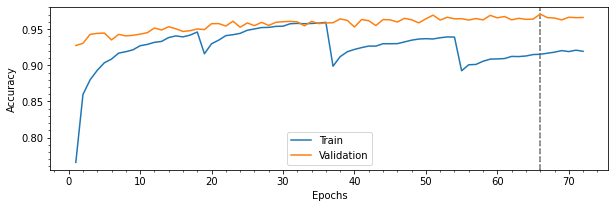

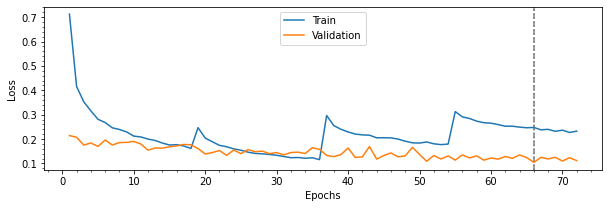

In [3]:
data = pd.read_csv('tmp/EffNetV2S_Pretrained_Prog.csv')
max_val_acc_epoch = np.argmax(data['val_accuracy'])+1
max_val_loss_epoch = np.argmin(data['val_loss'])+1
epochs = range(1, len(data['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,data['accuracy'], label='Train')
plt.plot(epochs,data['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,data['loss'], label='Train')
plt.plot(epochs,data['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

* Model performs the best out of all models
* Model is able to generalise very well
* Validation metrics are stable and no overfitting can be observed

<h3><b>Conclusions/Discussions</b></h3>

<p>In this classification task, we have succeeded in creating a model/pipeline that can achieve ~97% test accuracy, a test top 3 accuracy of ~99.8% and a test loss of 0.103, far exceeding the objective of attaining a model that can get >90% test accuracy. However, this was done using a model that was already pretrained on another dataset, meaning it would likely generalise better. </p>

<p>That's not to say that a model purely trained on the CIFAR-10 dataset alone can't perform well. Using the Progressive Learning training technique and RandAugment data augmentation, we were able to use EfficientNetV2-Small model and achieve a ~90% test accuracy, still reaching the goal. Compared to the baseline of ~79% test accuracy, that is a step up. </p>

<p>The increase in model complexity gave rise to an improvement in our performace as well as the reduction of overfitting, achieving our objective of the reduction of overfitting. </p>

<p>This also highlights the importance of training methods and regularization methods in improving model performance and computational cost, as the progressive learning method used has helped improve the model performance by dynamically adjusting image sizes and regularization amounts while training  model, with the regularization methods used being data augmentation via RandAugment and Dropout.</p>

<p>This has shown us that utilising different methods and regularisation can actually help our model generalise data better without significant addition to computational cost and complexity and even improving model performance.</p>

<p>We have also seen that using pretrained weights can be quite effective, though that might not always be feasible as the pretrained weights are not always available. But they should be used if available as they can give the model an added edge in generalising data. </p>

<p>Overall, our objectives have been achieved and the task concluded. From this, we have seen the importance of model complexity when it comes to dealing with more complex problems, like this CIFAR-10 dataset, which has 3 channel images that are 32x32. However, it is still a 10 class dataset, meaning that complex models should be still be able to perform quite well on this dataset, thought that may come with the added cost of increased training time and computational cost. However, that can somewhat be migtigated by training techniques like the one employed in this notebook, progressive training. </p>